<a href="https://colab.research.google.com/github/falahamro/Violent_Transnational_Social_Movements/blob/main/Step02_Data_Cleaning_and_NLP_Analysis_nodes_attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Cleaning

This notebook combines the previously scraped twitter data, cleans and add any additional columns needed prior to analysis.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Libraries

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Network analysis
import networkx as nx
import community as louvain

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from wordcloud import WordCloud

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec

# Machine learning
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Utilities
import warnings
import string
import re
import pickle
import gensim

# Load Dataset

In [3]:
df_connections = pd.read_csv("/content/drive/MyDrive/Social Network Analysis_Freedom Convoy/Final Query/ALL_nodes_connections_to_analysis (3).csv")

<ipython-input-3-33afa9f674e8>:1: DtypeWarning: Columns (5,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_connections = pd.read_csv("/content/drive/MyDrive/Social Network Analysis_Freedom Convoy/Final Query/ALL_nodes_connections_to_analysis (3).csv")


In [4]:
#, lineterminator='\n',dtype=str

In [5]:
df_connections =  df_connections.rename(columns = {"source" : "author.username"})

In [6]:
df_connections.head()

,author.username,target,text,author_id,id,in_reply_to_user_id,referenced_tweets.tweet.author.id,referenced_tweets.tweet.author.username,referenced_tweets.tweet.author_id,referenced_tweets.tweet.id,created_at,author.verified,author.location,author.description,conversation_id,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,referenced_tweets.id
0,QwertyDee_,SsWowowo,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18
1,QwertyDee_,1MikeMorris,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18
2,QwertyDee_,CandiceBergenMP,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18
3,Madrussianlives,TruckYouFrudeau,RT @TruckYouFrudeau: Oh good lord your bullshi...,1.495463e+18,1.498142e+18,NaN,1.492918e+18,TruckYouFrudeau,1492917845902118912.0,1498125519451299840.0,2022-02-28 03:44:14,False,NaN,A concerned citizen! Looking for the truth! Th...,1.498142e+18,236.0,587.0,14122.0,1.498126e+18
4,mrosssila,akatelyn19,RT @akatelyn19: Leaky Tank menu in #SarniaON \...,2.536917e+09,1.498142e+18,NaN,2.054286e+08,akatelyn19,205428649.0,1497250155174797312.0,2022-02-28 03:43:36,False,NaN,NaN,1.498142e+18,67.0,183.0,6542.0,1.497250e+18


In [7]:
df_connections.shape

(55759, 19)

In [8]:
#df_connections["created_at"] = df_connections["created_at"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S+00:000Z").replace(tzinfo=None))

# NLP Analysis

Use NLP and K-Means to cluster the different topics discussed in the tweets dataset.

# Sentiment Analysis

In [9]:
df_connections.head(3)

,author.username,target,text,author_id,id,in_reply_to_user_id,referenced_tweets.tweet.author.id,referenced_tweets.tweet.author.username,referenced_tweets.tweet.author_id,referenced_tweets.tweet.id,created_at,author.verified,author.location,author.description,conversation_id,author.public_metrics.followers_count,author.public_metrics.following_count,author.public_metrics.tweet_count,referenced_tweets.id
0,QwertyDee_,SsWowowo,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,20917723.0,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18
1,QwertyDee_,1MikeMorris,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,20917723.0,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18
2,QwertyDee_,CandiceBergenMP,RT @SsWowowo: @1MikeMorris @CandiceBergenMP #C...,20917723.0,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,2022-02-28 03:44:41,False,Canada,#WearAMask😷#N95 #DemocracyIsUnderThreat🇨🇦 Disi...,1.498142e+18,5040.0,5536.0,221894.0,1.498072e+18


In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
nltk.download('vader_lexicon')
from nltk.corpus import sentiwordnet as swn 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [12]:
from bs4 import BeautifulSoup
from html import unescape

def remove_urls(x):
    cleaned_string = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', str(x), flags=re.MULTILINE)
    return cleaned_string

In [13]:
def unescape_stuff(x):
    soup = BeautifulSoup(unescape(x), 'lxml')
    return soup.text

In [14]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [15]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9]+", ' ', x)
    return cleaned_string

In [16]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string

In [17]:
df_connections['text'] = df_connections['text'].str.lower()

In [18]:
df_connections['text'] = df_connections['text'].apply(remove_urls)
df_connections['text'] = df_connections['text'].apply(unescape_stuff)
df_connections['text'] = df_connections['text'].apply(deEmojify)
df_connections['text'] = df_connections['text'].apply(remove_symbols)
df_connections['text'] = df_connections['text'].apply(unify_whitespaces)

<ipython-input-13-cc4f7966ef48>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(unescape(x), 'lxml')


In [19]:
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
sp = spacy.load('en_core_web_sm')

cachedStopWords = sp.Defaults.stop_words
cachedStopWords = [x.lower() for x in cachedStopWords]
cachedStopWords.extend(list(stopwords.words('english')))
cachedStopWords = list(set(cachedStopWords))

def remove_stopwords(x):
    
    meaningful_words = []
    my_list = x
    
    tokenized_my_list = word_tokenize(my_list) 
    meaningful_words = [w for w in tokenized_my_list if not w in cachedStopWords]
        
    return " ".join(meaningful_words)

In [20]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [21]:
df_connections['text'] = df_connections['text'].apply(remove_stopwords)

In [22]:
tweets_sents=df_connections.text.values
tweets_words=[]
for x in tweets_sents:
    tweets_words.append(re.split(r'\s+',x))

In [23]:
#Lower Case
b=[]
c=[]
for x in tweets_words:
    for y in x:
        c.append(y.lower())
    b.append(c); c=[]
tweets_words=b
tweets_words[:3]

[['rt',
  'sswowowo',
  '1mikemorris',
  'candicebergenmp',
  'convoycandice',
  'love',
  'chickenvoy',
  'clownvoy2022',
  'freedomconvoy',
  'ottawastrong',
  'lawandorder'],
 ['rt',
  'sswowowo',
  '1mikemorris',
  'candicebergenmp',
  'convoycandice',
  'love',
  'chickenvoy',
  'clownvoy2022',
  'freedomconvoy',
  'ottawastrong',
  'lawandorder'],
 ['rt',
  'sswowowo',
  '1mikemorris',
  'candicebergenmp',
  'convoycandice',
  'love',
  'chickenvoy',
  'clownvoy2022',
  'freedomconvoy',
  'ottawastrong',
  'lawandorder']]

In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [26]:
tweets_sents=[]
#Lemmatize using WordNetLemmatizer
for x in tweets_words:
    for y in x:
        lemma= nltk.WordNetLemmatizer()
        c.append(lemma.lemmatize(y))
    tweets_sents.append(c);
tweet_words=tweets_sents;c=[];tweets_sents=[]

In [27]:
#Remove Stopwords From The Tweets
stopwords=nltk.corpus.stopwords.words('english')
b=[]
c=[]
for x in tweets_words:
    for y in x:
        if y not in stopwords:
            c.append(y)
    b.append(c);c=[]
for x in b:
    tweets_sents.append(' '.join(x))

In [28]:
#Extract Words And Tweets Only From the Data
b=[]
c=[]
for x in tweets_sents:
    b.append(re.findall(r'#?[a-zA-Z]+',x))
tweets_words=b; tweets_sents=[]
for x in b:
    tweets_sents.append(' '.join(x))
tweets_sents[:5]

['rt sswowowo mikemorris candicebergenmp convoycandice love chickenvoy clownvoy freedomconvoy ottawastrong lawandorder',
 'rt sswowowo mikemorris candicebergenmp convoycandice love chickenvoy clownvoy freedomconvoy ottawastrong lawandorder',
 'rt sswowowo mikemorris candicebergenmp convoycandice love chickenvoy clownvoy freedomconvoy ottawastrong lawandorder',
 'rt truckyoufrudeau oh good lord bullshit knows bounds hear words come mouth trudea',
 'rt akatelyn leaky tank menu sarniaon restaurant followed legislation masks vaccine passports boasted']

In [29]:
vadler_scores=[]
for x in tweets_sents:
    analyzer=SentimentIntensityAnalyzer()
    vadler_scores.append(analyzer.polarity_scores(x))
vadler_scores[:5]

[{'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.6369},
 {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.6369},
 {'neg': 0.0, 'neu': 0.704, 'pos': 0.296, 'compound': 0.6369},
 {'neg': 0.215, 'neu': 0.621, 'pos': 0.164, 'compound': -0.2263},
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}]

In [30]:
vadler_df=pd.DataFrame(vadler_scores)
sentiments=[]
for x in vadler_df['compound']:
    if x<0:
        sentiments.append('Negative');
    elif x==0:
        sentiments.append('Neutral');
    elif x>0:
        sentiments.append('Positive');
vadler_df['Sentiments']=sentiments
vadler_df['Tweets']=tweets_words
vadler_df.head()

,neg,neu,pos,compound,Sentiments,Tweets
0,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
1,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
2,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
3,0.215,0.621,0.164,-0.2263,Negative,"[rt, truckyoufrudeau, oh, good, lord, bullshit..."
4,0.000,1.000,0.000,0.0000,Neutral,"[rt, akatelyn, leaky, tank, menu, sarniaon, re..."


In [31]:
import matplotlib.pyplot as plt

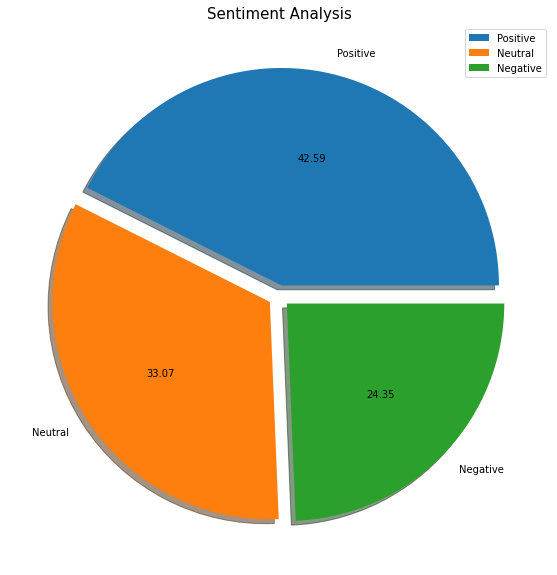

Fig 1.2


In [32]:
#Pie Chart of sentiments
plt.figure(figsize=(10,10))
plt.title('Sentiment Analysis',size=15)
plt.pie(vadler_df.Sentiments.value_counts().values,labels=['Positive','Neutral','Negative'],explode=[0.05,0.05,0.05],autopct='%.2f', shadow=True)
plt.legend(loc='upper right')
plt.show()
print('Fig 1.2')

<Figure size 720x720 with 0 Axes>

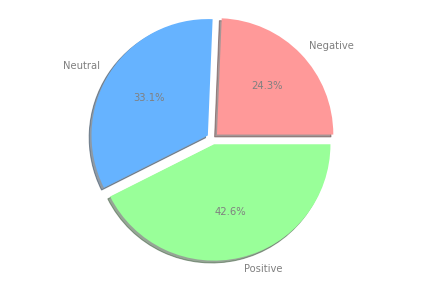

In [33]:
import matplotlib.pyplot as plt
# Pie chart
plt.figure(figsize=(10,10))

labels = ['Negative', 'Neutral', 'Positive']
sizes = [24.35, 33.07, 42.59]
#colors
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', explode=[0.05,0.05,0.05], shadow=True)
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

Cluster 0 sentiment visualization


<Figure size 720x720 with 0 Axes>

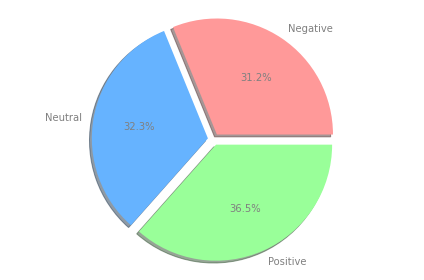

In [34]:
import matplotlib.pyplot as plt
# Pie chart
plt.figure(figsize=(10,10))

labels = ['Negative', 'Neutral', 'Positive']
sizes = [31.17, 32.29, 36.54]
#colors
colors = ['#ff9999','#66b3ff','#99ff99']
 
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', explode=[0.05,0.05,0.05], shadow=True)
for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [35]:
#Adding Sr.No. column to valder_df
vadler_df = vadler_df.reset_index()
vadler_df = vadler_df.rename(columns={"index":"Sr.No."})
vadler_df['Sr.No.'] = vadler_df.index + 0

In [36]:
vadler_df.head()

,Sr.No.,neg,neu,pos,compound,Sentiments,Tweets
0,0,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
1,1,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
2,2,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
3,3,0.215,0.621,0.164,-0.2263,Negative,"[rt, truckyoufrudeau, oh, good, lord, bullshit..."
4,4,0.000,1.000,0.000,0.0000,Neutral,"[rt, akatelyn, leaky, tank, menu, sarniaon, re..."


In [37]:
df_connections = pd.concat([df_connections, vadler_df], axis=1)

In [38]:
df_connections

,author.username,target,text,author_id,id,in_reply_to_user_id,referenced_tweets.tweet.author.id,referenced_tweets.tweet.author.username,referenced_tweets.tweet.author_id,referenced_tweets.tweet.id,...,author.public_metrics.following_count,author.public_metrics.tweet_count,referenced_tweets.id,Sr.No.,neg,neu,pos,compound,Sentiments,Tweets
0,QwertyDee_,SsWowowo,rt sswowowo 1mikemorris candicebergenmp convoy...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,...,5536.0,221894.0,1.498072e+18,0,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
1,QwertyDee_,1MikeMorris,rt sswowowo 1mikemorris candicebergenmp convoy...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,...,5536.0,221894.0,1.498072e+18,1,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
2,QwertyDee_,CandiceBergenMP,rt sswowowo 1mikemorris candicebergenmp convoy...,2.091772e+07,1.498142e+18,NaN,7.133665e+17,SsWowowo,713366495527481344.0,1498072291153874944.0,...,5536.0,221894.0,1.498072e+18,2,0.000,0.704,0.296,0.6369,Positive,"[rt, sswowowo, mikemorris, candicebergenmp, co..."
3,Madrussianlives,TruckYouFrudeau,rt truckyoufrudeau oh good lord bullshit knows...,1.495463e+18,1.498142e+18,NaN,1.492918e+18,TruckYouFrudeau,1492917845902118912.0,1498125519451299840.0,...,587.0,14122.0,1.498126e+18,3,0.215,0.621,0.164,-0.2263,Negative,"[rt, truckyoufrudeau, oh, good, lord, bullshit..."
4,mrosssila,akatelyn19,rt akatelyn19 leaky tank menu sarniaon restaur...,2.536917e+09,1.498142e+18,NaN,2.054286e+08,akatelyn19,205428649.0,1497250155174797312.0,...,183.0,6542.0,1.497250e+18,4,0.000,1.000,0.000,0.0000,Neutral,"[rt, akatelyn, leaky, tank, menu, sarniaon, re..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55754,Stand_Records,ChiefsofMayhem,chiefsofmayhem breitbartnews check killwillc r...,1.471235e+18,1.495189e+18,2792704009,2.792704e+09,ChiefsofMayhem,2792704009,1495184585608544259,...,143.0,27.0,1.495185e+18,55754,0.000,0.781,0.219,0.6369,Positive,"[chiefsofmayhem, breitbartnews, check, killwil..."
55755,Stand_Records,BreitbartNews,chiefsofmayhem breitbartnews check killwillc r...,1.471235e+18,1.495189e+18,2792704009,2.792704e+09,ChiefsofMayhem,2792704009,1495184585608544259,...,143.0,27.0,1.495185e+18,55755,0.000,0.781,0.219,0.6369,Positive,"[chiefsofmayhem, breitbartnews, check, killwil..."
55756,Stand_Records,KillWillC,chiefsofmayhem breitbartnews check killwillc r...,1.471235e+18,1.495189e+18,2792704009,2.792704e+09,ChiefsofMayhem,2792704009,1495184585608544259,...,143.0,27.0,1.495185e+18,55756,0.000,0.781,0.219,0.6369,Positive,"[chiefsofmayhem, breitbartnews, check, killwil..."
55757,Stand_Records,RealBrysonGray,chiefsofmayhem breitbartnews check killwillc r...,1.471235e+18,1.495189e+18,2792704009,2.792704e+09,ChiefsofMayhem,2792704009,1495184585608544259,...,143.0,27.0,1.495185e+18,55757,0.000,0.781,0.219,0.6369,Positive,"[chiefsofmayhem, breitbartnews, check, killwil..."


# Word2Vec Modeling

In [42]:
def preprocess(text):
    text_input = re.sub('[^a-zA-Z1-9]+', ' ', str(text))
    output = re.sub(r'\d+', '',text_input)
    return output.lower().strip()

df_connections['text'] = df_connections['text'].apply(preprocess)
#df_connections.head()  # Uncomment if you want to see the preprocessed text

In [45]:
from nltk.corpus import stopwords

stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

df_connections['text'] = df_connections['text'].apply(remove_stopwords)


In [44]:
'''
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

df_connections['text'] = df_connections.text.map(remove_stopwords)
#df_connections

'''

AttributeError: ignored

In [47]:
def build_corpus(df):
    corpus = []
    for sentence in df.iteritems():
        word_list = sentence[1].split(" ")
        corpus.append(word_list)
    return corpus

corpus = build_corpus(df_connections['text'])

In [48]:
model = Word2Vec(corpus, size=100, min_count=1)

In [49]:
model.wv.save_word2vec_format('word2vec_embedding.bin', binary=True)

Word2Vec Clustering

In [50]:
abst_list = df_connections['text'].values.astype('U')

In [51]:
#preprocessing for pubmed data
nopunc = str.maketrans('', '', string.punctuation)
lem = WordNetLemmatizer()
custom_stopwords = set(stopwords.words("english")+ [])
custom_stopwords = [lem.lemmatize(word) for word in custom_stopwords]

In [52]:
def preprocess(abst_list):
    abstracts =[]
    for line in abst_list:
        line.replace("\n", "")
        line = line.lower()
        line = line.translate(nopunc)
        line = re.sub('[^A-Za-z]', ' ', line)
        new = ' '
        for word in line.split():
            word = lem.lemmatize(word)
            if word not in custom_stopwords and len(word)>3:
                new = new + ' ' + word
        abstracts.append(new)
    return abstracts

In [53]:
abstract_list = preprocess(abst_list)

In [54]:
abstract_list[0]

'  sswowowo mikemorris candicebergenmp convoycandice love chickenvoy clownvoy freedomconvoy ottawastrong lawandorder'

In [55]:
def tokenizer(abst_list):
    abstract_tokens =[]
    for line in abst_list:
        tokens = word_tokenize(line)
        tokens = [t for t in tokens if len(t) > 3]
        abstract_tokens.append(tokens)
    return abstract_tokens

In [56]:
abstract_tokens = tokenizer(abstract_list)

** Word Vectotization**

In [57]:
vectorizer = KeyedVectors.load_word2vec_format('word2vec_embedding.bin', binary=True)

In [58]:
def w2v_vectorizer(list_of_docs, model):
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [59]:
text_vectors = w2v_vectorizer(abstract_tokens,vectorizer)

# Model building

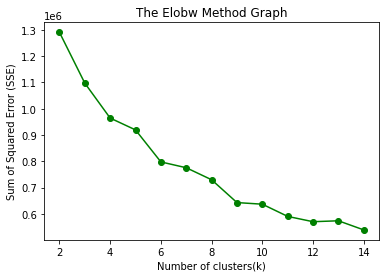

In [60]:
# checking for optimal number of clusters
sse = []
list_k = list(range(2,15))

for k in list_k:
    km = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
    km.fit(text_vectors)
    sse.append(km.inertia_)

plt.plot(range(2, 15), sse, 'go-')
plt.title('The Elobw Method Graph')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Sum of Squared Error (SSE)')
plt.show()

In [61]:
k = 4
k_means = MiniBatchKMeans(init='k-means++',n_clusters = k,random_state=0,n_init=20,max_iter=1000)
k_means.fit(text_vectors)

MiniBatchKMeans(max_iter=1000, n_clusters=4, n_init=20, random_state=0)

# Visualization

In [62]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=0)
reduced_vectors = pca.fit_transform(text_vectors)
reduced_clusters = pca.fit_transform(k_means.cluster_centers_)

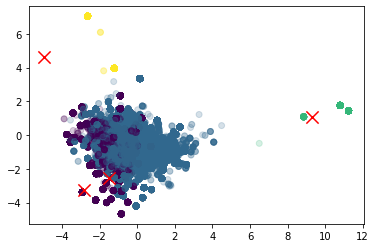

In [63]:
plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_, alpha=0.2)
plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

# Top words from each cluster

In [64]:
df_connections['preprocessed_abstract'] = abstract_list
df_connections['labels'] = k_means.labels_
df_connections['labels'].value_counts()

1    37749
0    11030
3     3732
2     3248
Name: labels, dtype: int64

In [80]:
from sklearn.metrics import calinski_harabasz_score

# initialize k-means with k clusters
kmeans = KMeans(n_clusters=5, random_state=42)

# fit the k-means model to the data
kmeans.fit(text_vectors)

# calculate the Calinski-Harabasz score for the clustering solution
ch_score = calinski_harabasz_score(text_vectors, kmeans.labels_)
print("Calinski-Harabasz score:", ch_score)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Calinski-Harabasz score: 14006.56029627506


In [81]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score

# initialize DBSCAN with eps=0.5 and min_samples=5
dbscan = DBSCAN(eps=0.5, min_samples=5)

# fit the DBSCAN model to the data
dbscan.fit(text_vectors)

# calculate the Calinski-Harabasz score for the clustering solution
ch_score = calinski_harabasz_score(text_vectors, dbscan.labels_)
print("Calinski-Harabasz score:", ch_score)

Calinski-Harabasz score: 1324.065975416027


In [ ]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score

# initialize SpectralClustering with k=5
spectral = SpectralClustering(text_vectors=4, random_state=42)

# fit the SpectralClustering model to the data
spectral.fit(X)

# calculate the Calinski-Harabasz score for the clustering solution
ch_score = calinski_harabasz_score(Xtext_vectors, spectral.labels_)
print("Calinski-Harabasz score:", ch_score)

In [65]:
def get_top_n_words(corpus, n):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [66]:
def get_wordcloud(text):
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

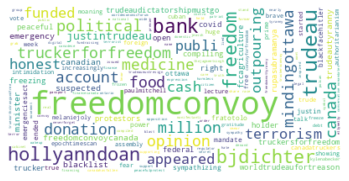

Top 10 words from cluster 0 :
['freedomconvoy', 'trudeau', 'bank', 'freedom', 'hollyanndoan', 'bjdichter', 'canada', 'political', 'million', 'truckerforfreedom']


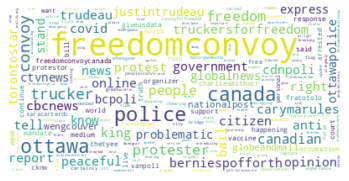

Top 10 words from cluster 1 :
['freedomconvoy', 'police', 'ottawa', 'canada', 'convoy', 'trucker', 'protester', 'freedom', 'people', 'canadian']


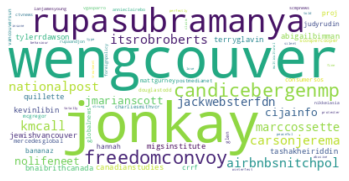

Top 10 words from cluster 2 :
['wengcouver', 'jonkay', 'rupasubramanya', 'candicebergenmp', 'freedomconvoy', 'airbnbsnitchpol', 'kmcall', 'itsrobroberts', 'carsonjerema', 'nationalpost']


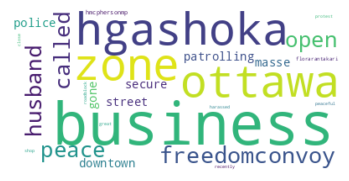

Top 10 words from cluster 3 :
['business', 'hgashoka', 'ottawa', 'zone', 'freedomconvoy', 'husband', 'called', 'open', 'peace', 'police']


In [67]:
from wordcloud import WordCloud
for clus in range (4):
    text =' '
    df2 = df_connections.loc[df_connections["labels"]==clus]
    
    #wordcloud
    for abst in df2.preprocessed_abstract:
        text += abst
    get_wordcloud(text)
    
    #top10words
    words = []
    for i, j in get_top_n_words(df2["preprocessed_abstract"],10):
        words.append(i)
    print ("Top 10 words from cluster",clus,":")
    print (words)

In [71]:
pip install -U yellowbrick

NotImplementedError: ignored

In [72]:
# initialize the vectorizer 

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)


X = vectorizer.fit_transform(df_connections['preprocessed_abstract'])

In [73]:
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

In [74]:
from sklearn.cluster import KMeans

In [75]:
visualizer = KElbowVisualizer(KMeans(init="k-means++", random_state=42), k=(1, 10))
visualizer.fit(X)        
visualizer.show() 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


TypeError: ignored

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


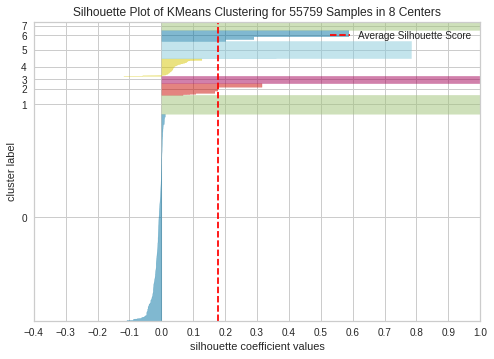

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 55759 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [76]:
visualizer = SilhouetteVisualizer(KMeans(init="k-means++", random_state=42), colors='yellowbrick')
visualizer.fit(X)        
visualizer.show() 

In [77]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
#pass X to the pca and store the reduced vectors into pca_vecs 
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1

x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:
# assign clusters and pca vectors to our dataframe 

df_connections['clusters'] = k_means.labels_
df_connections['x0'] = x0
df_connections['x1'] = x1

In [ ]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Word2Vec + KMeans Tweet clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_connections, x='x0', y='x1', hue='labels', palette="viridis")
plt.show()

In [ ]:
#df_connections.head()

In [ ]:
#for i in range(df_connections.shape[0]) :
#     if (df_connections.iloc[i]["clusters"] == 1) :
#         print("Cluster:", df_connections.iloc[i]["clusters"])
#         print(df_connections.iloc[i]["text"])
#         print("------------")

After looking through the different clusters and its separations, we have determined that the tweet categories can be separated fairly well with only 5 clusters. Therefore, only the results of the 5 clusters are kept.

In [ ]:
#join the 5_cluster separation with tweet data
#nlp_clusters = pd.DataFrame(tweets["5_clusters"])
#nlp_clusters = nlp_clusters.rename(columns = {"5_clusters" : "nlp_clusters"})
#df_connections = df_connections.join(nlp_clusters, on = "id")

In [ ]:
df_connections = df_connections.reset_index()

In [ ]:
# label clusters with their relevant categories
df_connections["clusters"] = df_connections["clusters"].astype(str)
df_connections["clusters"] = df_connections["clusters"].replace({"0" : "Anti-gov rhetoric",
                                                                 "1" : "FreedomConvoy Funding",
                                                                 "2" : "Movement",
                                                                 "3" : "Gov-policy",
                                                                 "4" : "Protest",
                                                                 "5" : "Political Rhetoric",
                                                                 "6" : "Police",
                                                                 "7" : "Vaccine-Liberty",
                                                              
                                                                         })

In [ ]:
df_connections.to_csv("/content/drive/MyDrive/Social Network Analysis_Freedom Convoy/Final Query/ALL_nodes_connections_final_after_content_analysis_8_clusters.csv", index=False)

In [ ]:
df_connections.loc[df_connections['author.username'] == 'QwertyDee_']

# Word2Vec

In [ ]:
w2v_df = df_connections.copy()

In [ ]:
w2v_df

In [ ]:
tokenized_tweet = w2v_df['text'].apply(lambda x: x.split()) # tokenizing 

In [ ]:
tokenized_tweet = w2v_df['preprocessed_abstract'].apply(lambda x: x.split()) # tokenizing 

In [ ]:
w2v_df['preprocessed_abstract']

# Build word2vec model

In [ ]:
import gensim

In [ ]:
w2v_model = gensim.models.Word2Vec(tokenized_tweet, size=100, window=6, min_count=3, sg = 1, hs = 0, negative = 10, workers=32, seed = 34)

w2v_model.train(tokenized_tweet, total_examples= len(w2v_df['preprocessed_abstract']), epochs=20)

In [ ]:
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics

In [ ]:
from nltk.cluster import KMeansClusterer
from sklearn import cluster
from sklearn import metrics

Z = w2v_model[w2v_model.wv.vocab]

NUM_CLUSTERS=7
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Z, assign_clusters=True)
 
words = list(w2v_model.wv.vocab)

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
# put labels into the original dataset
w2v_df['KMeans_w2v_2'] = kmeans.labels_

In [ ]:
w2v_df.head()

In [ ]:
#w2v_df.to_csv("visualization_pca.cvs")

In [ ]:
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
#pass X to the pca and store the reduced vectors into pca_vecs 
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1

x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:

# assign clusters and pca vectors to our dataframe 

w2v_df['clusters'] = kmeans.labels_
w2v_df['x0'] = x0
w2v_df['x1'] = x1

In [ ]:
w2v_df.head()

##visualization

In [ ]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Word2Vec + KMeans Tweet clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=w2v_df, x='x0', y='x1', hue='KMeans_w2v_2', palette="viridis")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=2, random_state=0)
#reduced_vectors = pca.fit_transform(x.toarray)
#reduced_clusters = pca.fit_transform(kmeans.cluster_centers_)

In [ ]:
#plt.scatter(reduced_vectors[:,0],reduced_vectors[:,1],c=k_means.labels_, alpha=0.2)
#plt.scatter(reduced_clusters[:, 0],reduced_clusters[:, 1], marker='x', s=150, c='r')

In [ ]:
my_cluster={}
for i, word in enumerate(words):  
    my_cluster[word] = str(assigned_clusters[i])

from collections import defaultdict 
  
res = defaultdict(list) 
for key, val in sorted(my_cluster.items()): 
    res[val].append(key) 
      
for key,value in dict(res).items():
    print("Group",key,":",value)
    print() 

Identifying the Similarity between the tweets.


In [ ]:
def w2v(s1,s2,wordmodel):
            if s1==s2:
                    return 1.0
            s1words=s1.split()
            s2words=s2.split()
            
            s1wordsset=set(s1words)
            s2wordsset=set(s2words)
            
            vocab = wordmodel.wv.vocab #the vocabulary considered in the word embeddings
         
            for word in s1wordsset.copy(): #remove sentence words not found in the vocab
                    if (word not in vocab):
                            s1words.remove(word)
            for word in s2wordsset.copy(): 
                    if (word not in vocab):
                            s2words.remove(word)
            print(s1words)
            print(s2words)
            return wordmodel.wv.n_similarity(s1words, s2words)

In [ ]:
s1=w2v_df['preprocessed_abstract'][233]
s2=w2v_df['preprocessed_abstract'][543]

In [ ]:
s1

In [ ]:
s2

In [ ]:
w2v(s1,s2, w2v_model)

In [ ]:
w2v_model.wv.most_similar("moral")